In [2]:
!pip install pylatex

  Using cached PyLaTeX-1.4.2-py3-none-any.whl
  Using cached ordered_set-4.1.0-py3-none-any.whl.metadata (5.3 kB)
Using cached ordered_set-4.1.0-py3-none-any.whl (7.6 kB)


In [3]:
import os
import uuid
import shutil
import pylatex
import pandas as pd
import lightkurve as lk 
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm.notebook import tqdm
from multiprocessing import cpu_count, Pool
from pylatex.section import Chapter, Subsection
from pylatex import Document, Section, Figure, NoEscape, Command

plt.ioff()
%run pipeline.ipynb

OUTPUT_PATH = "/home/jovyan/SRMP-JMAG/output"

In [ ]:
def get_sectors(tic):
    """Returns a list of available sectors given an TIC."""
    sectors = []
    for result in lk.search_tesscut(str(tic)):
        sectors.append(int(result.mission[0].split(" ")[2]))
        
    return {"tic": tic, "sectors": sectors}

def get_targets(tics):
    """Constructs a dictionary of TICs and available sectors from a list of TICs"""
    targets = []

    with tqdm(total=len(tics)) as pbar:
        for tic in tics:
            targets.append(get_sectors(tic))
            pbar.update()
    return targets
                
targets = get_targets(pd.read_csv("./stars.csv")["TIC"][0:3])


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
complex = {}
not_complex = {}

# This first loop will populate the list of complex and non-complex stars
for target in targets:
    for sector in target["sectors"]:
        if sector <= 56: # FFIs are only high enough res after cycle (year) 5.
            continue
        lc = load_lc(f"{target['tic']}", sector)
            
        # Determine complexity
        if complexitycheck(lc):
            if target["tic"] not in complex.keys():
                complex[target["tic"]] = []
            complex[target["tic"]].append(sector)
        else:
            if target["tic"] not in not_complex.keys():
                not_complex[target["tic"]] = []
            not_complex[target["tic"]].append(sector)
        if not os.path.isdir(f"{OUTPUT_PATH}/{target['tic']}"):
            os.mkdir(f"{OUTPUT_PATH}/{target['tic']}")

        # # Plot river and save
        # plt.figure(river_plot(lc).number) # this is necessary to make the output current and save the correct figure.
        # plt.savefig(f"{OUTPUT_PATH}/{target['tic']}/{sector}_river.png")
        # plt.close()

        # Plot lc and save
        plt.figure(graph_lc(lc).number) 
        plt.savefig(f"{OUTPUT_PATH}/{target['tic']}/{sector}_plot.png")
        plt.close()

        # # Lombscargle lc and save
        # plt.figure(lombscargle(lc).number) 
        # plt.savefig(f"{OUTPUT_PATH}/{target['tic']}/{sector}_periodogram.png")
        # plt.close()


        # TODO: Periodogram when fixed.

Inflating...
Removing 1425 bad data points (out of 10856) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 80 bad data points (out of 11356) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 421 bad data points (out of 11639) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 229 bad data points (out of 11719) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 1001 bad data points (out of 10856) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 248 bad data points (out of 11190) using the TESS provided QUALITY array
Summing over 1 x 1 pixel lightcurves. Weighting=None
Inflating...
Removing 26 bad data points (out of 10837) us

In [5]:
def make_dataframes(l):
    
    df = pd.DataFrame()
    
    tics = []
    sectors = []
    for tic in list(l.keys()):
        for sector in l[tic]:
            tics.append(tic)
            sectors.append(sector)
    
    df["TIC"] = tics
    df["Sectors"] = sectors

    return df

make_dataframes(complex).to_csv(f"{OUTPUT_PATH}/complex.csv")
make_dataframes(not_complex).to_csv(f"{OUTPUT_PATH}/not_complex.csv")

In [8]:
def make_chapter(title, data, doc):
    with doc.create(Chapter(title)):
        for tic in data.keys():
            doc.append(NoEscape(r'\newpage'))
            with doc.create(Section(f"{tic}")):
                for i, sector in enumerate(data[tic]):
                    if i > 0:
                        doc.append(NoEscape(r'\newpage'))
                    with doc.create(Subsection(f"Sector {sector}", label=f"{tic}_{sector}")):
                        lc = load_lc(f"{tic}", sector)

                        for plot_type in ["plot", "river", "periodogram"]:
                            with doc.create(Figure(position="H")) as plot:
                                doc.append(NoEscape(r'\begin{center}'))
                                plot.add_image(f"{OUTPUT_PATH}/{tic}/{sector}_{plot_type}.png")
                                doc.append(NoEscape(r'\end{center}'))
                        # This is the old code. It generates each plot as a PGF.
                        # PGFs have the benefit of being able to scale to higher resolutions
                        # But generating the plots twice takes longer, so the current code uses the PNGs generated by the pipeline.

                        # plt.figure(river_plot(lc).number)
                        # with doc.create(Figure(position='H')) as plot:
                        #     doc.append(NoEscape(r'\begin{center}'))
                        #     plot.add_plot(width=NoEscape(r'0.5\textwidth'))
                        #     doc.append(NoEscape(r'\end{center}'))
                        # plt.close()

                        # plt.figure(graph_lc(lc).number)
                        # with doc.create(Figure(position='H')) as plot:
                        #     doc.append(NoEscape(r'\begin{center}'))
                        #     plot.add_plot(width=NoEscape(r'0.5\textwidth'))
                        #     doc.append(NoEscape(r'\end{center}'))
                        # plt.close()

                        # plt.figure(lombscargle(lc).number)
                        # with doc.create(Figure(position='H')) as plot:
                        #     doc.append(NoEscape(r'\begin{center}'))
                        #     plot.add_plot(width=NoEscape(r'0.5\textwidth'))
                        #     doc.append(NoEscape(r'\end{center}'))
                        # plt.close()

def make_pdf_report():
    try:
        shutil.rmtree("./build")
    except:
        pass
    os.mkdir("./build")

    doc = Document(documentclass="report", lmodern=False, geometry_options={"margin": "0.5in", "top": "0.5in", "bottom": "0.5in"})

    doc.preamble.append(Command("title", "JMAG Complex Rotator Pipeline Results"))
    doc.preamble.append(Command("date", f"Generated on {datetime.now().strftime('%x %X')}"))
    doc.preamble.append(NoEscape(r'\usepackage{float}'))
    doc.preamble.append(NoEscape(r'\usepackage{hyperref}'))
    doc.preamble.append(NoEscape(r'\hypersetup{colorlinks=true}'))


    doc.append(NoEscape(r'\maketitle'))
    doc.append(NoEscape(r'\tableofcontents'))
    
    make_chapter("Complex Rotators", complex, doc)
    make_chapter("Non-Complex Rotators", not_complex, doc)
    doc.generate_tex("./build/main")
    
    os.system("cd build && pdflatex -interaction=nonstopmode main.tex && pdflatex -interaction=nonstopmode main.tex")
    
make_pdf_report()

This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019/Debian) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./main.tex
LaTeX2e <2020-02-02> patch level 2
L3 programming layer <2020-02-14>
(/usr/share/texlive/texmf-dist/tex/latex/base/report.cls
Document Class: report 2019/12/20 v1.4l Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/base/fontenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/lastpage/lastpage.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/graphics/graphicx.sty
(/usr/share/texlive/texmf-dis

Started TIC 237883499:68
Done
Started TIC 237883499:69
Done
Started TIC 262874398:68
Done
Started TIC 262874398:61
Done
Started TIC 262874398:69
Failed
Started TIC 262874398:64
Done
Started TIC 33736757:68
Done
Started TIC 33736757:67


/opt/conda/envs/tess/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Done
Started TIC 33736757:66
Done
Started TIC 33736757:65
Done
Started TIC 33736757:61
Done
Started TIC 33736757:69
Done
Started TIC 33736757:63
Done
Started TIC 33736757:62
Done
Started TIC 33736757:64
Done


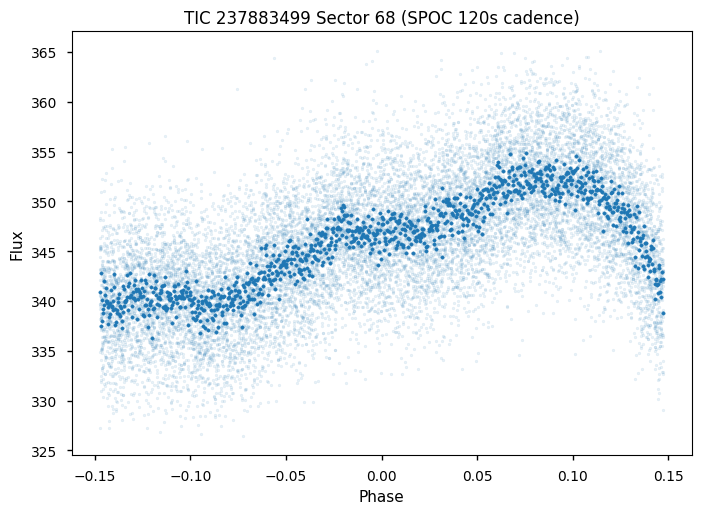

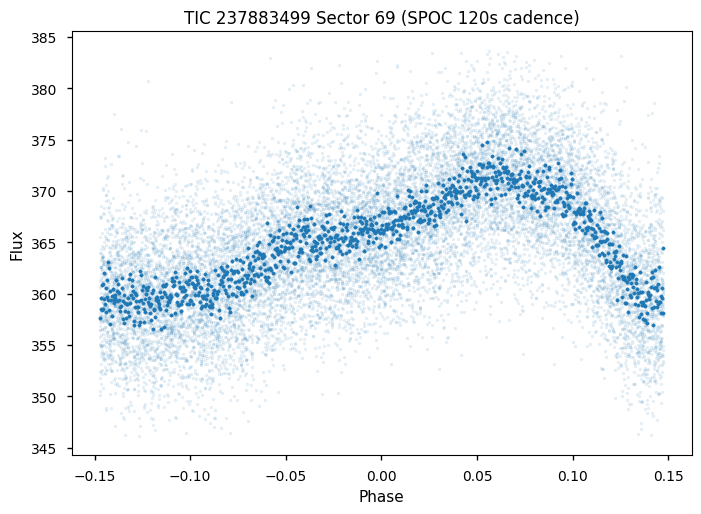

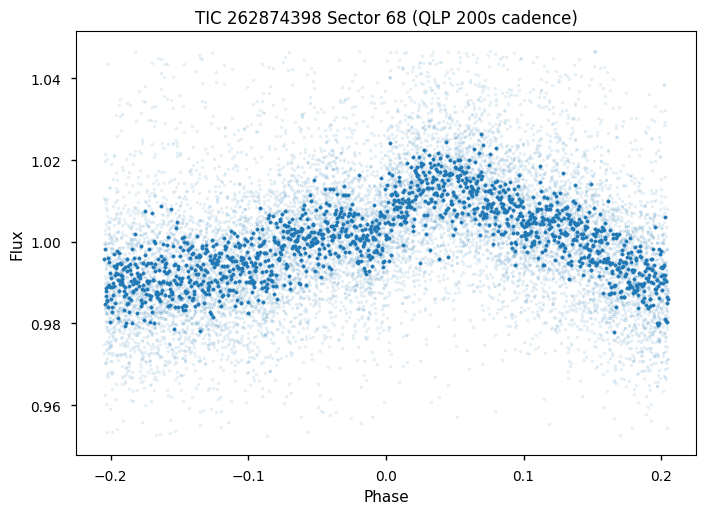

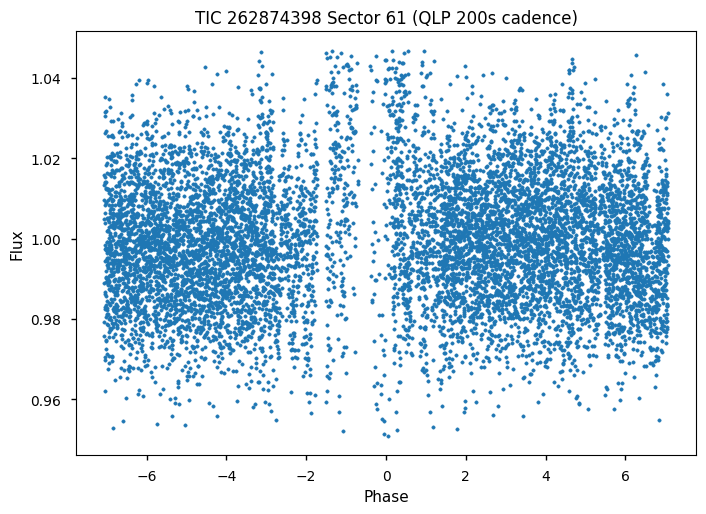

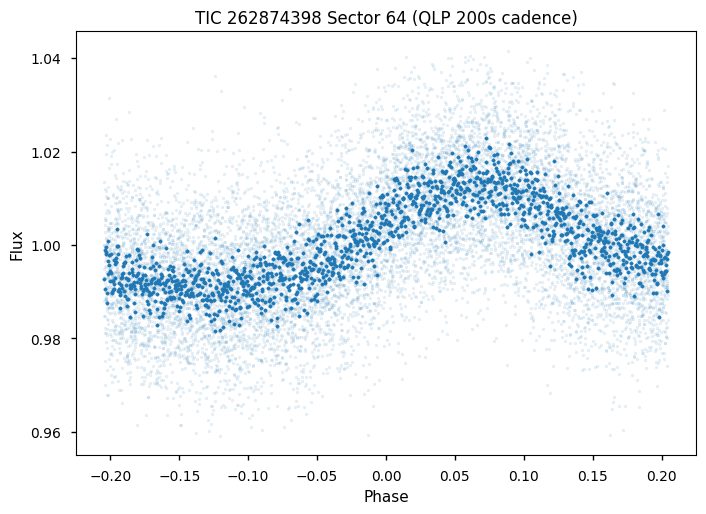

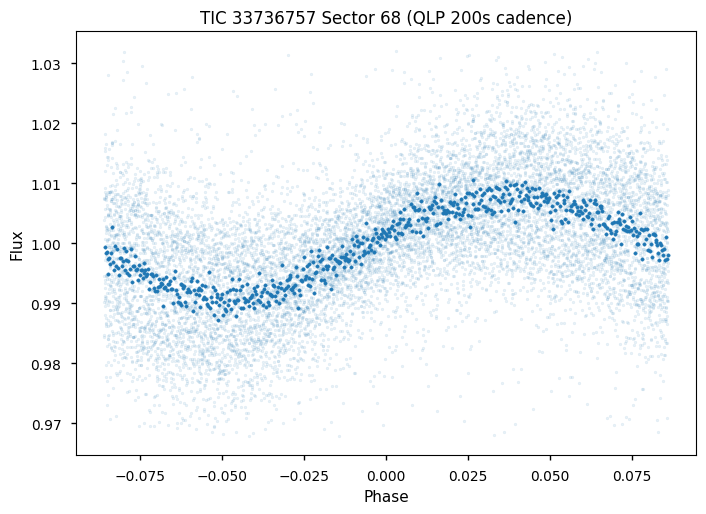

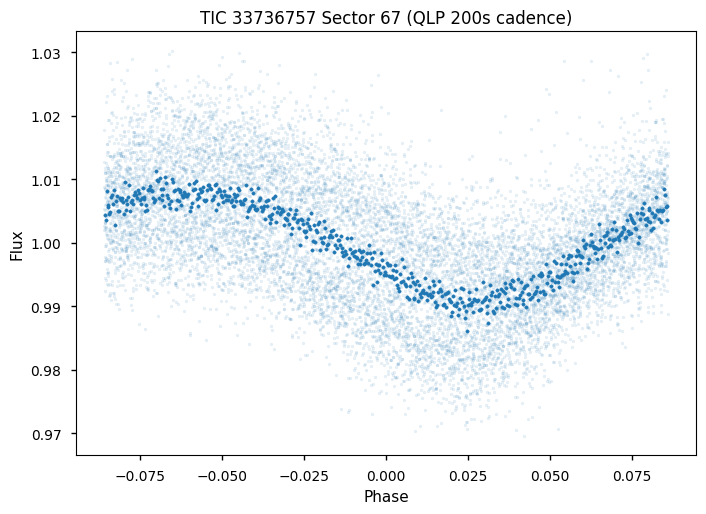

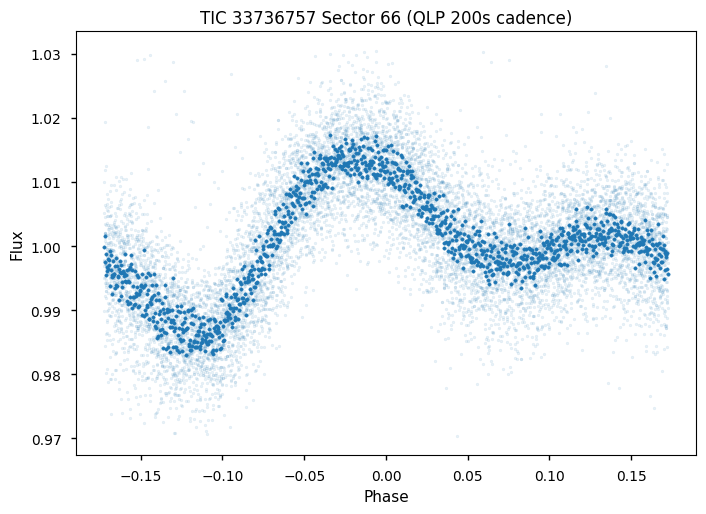

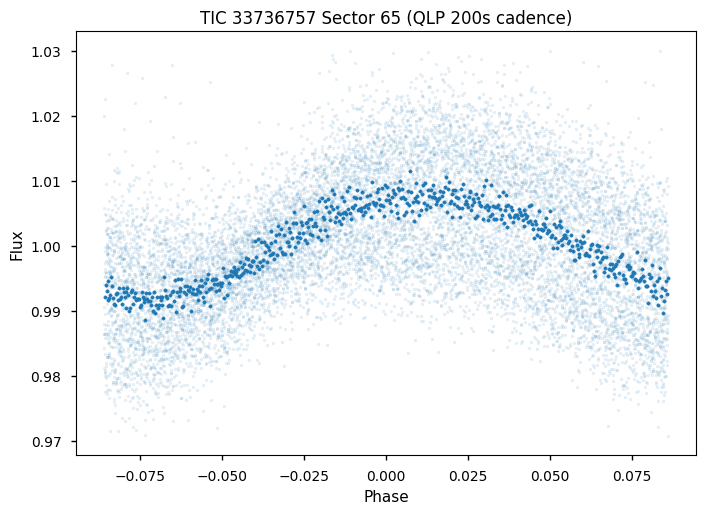

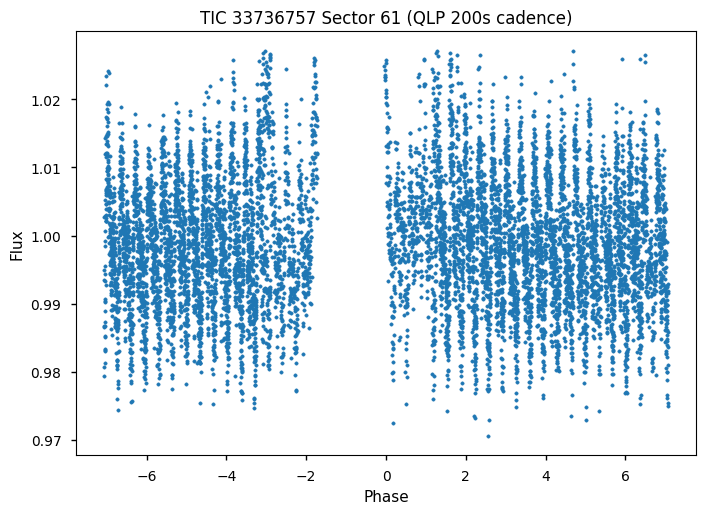

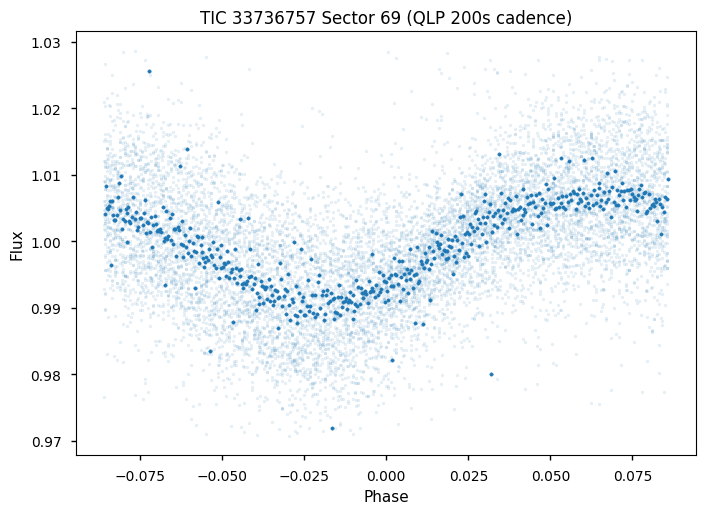

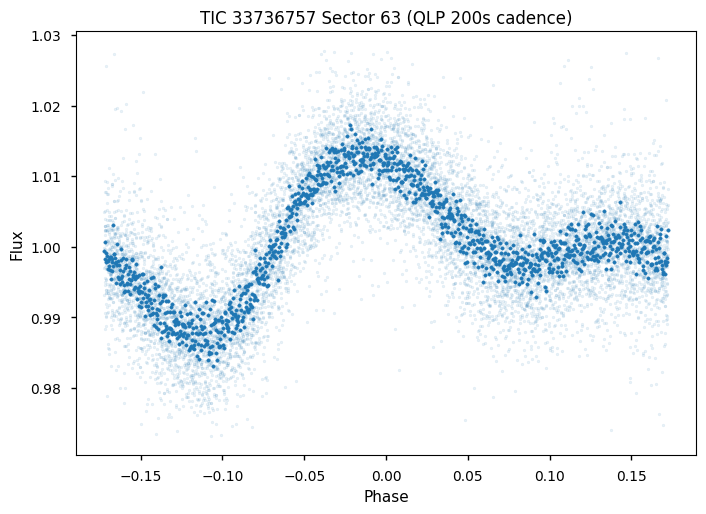

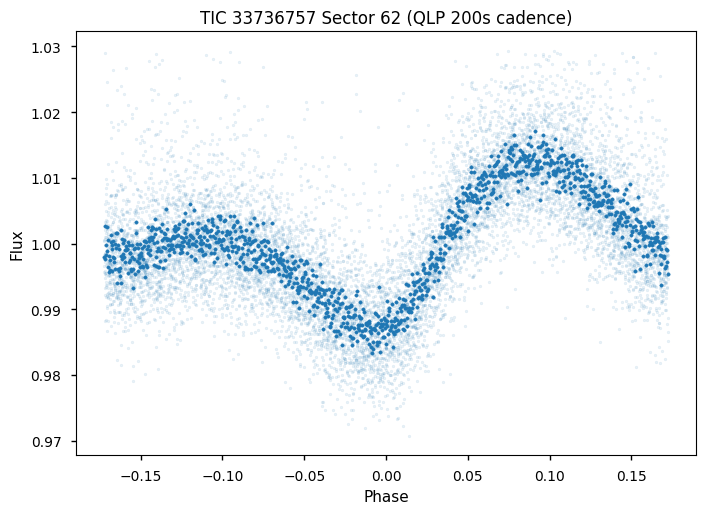

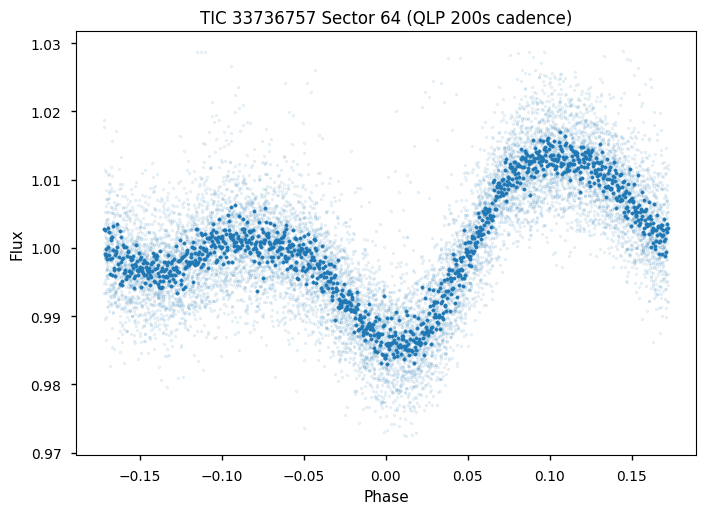

In [8]:
doc = Document(documentclass="report", lmodern=False, geometry_options={"margin": "0.5in", "top": "0.5in", "bottom": "0.5in"})

doc.preamble.append(Command("title", "JMAG SPOC Pipeline Comparison"))
doc.preamble.append(Command("date", f"Generated on {datetime.now().strftime('%x %X')}"))
doc.preamble.append(NoEscape(r'\usepackage{float}'))

for tic in list(complex.keys()):
    for sector in complex[tic]:
        try:
            print(f"Started {tic}:{sector}")
            result = lk.search_lightcurve(tic, sector=sector)[0]
            plt.figure(graph_lc(result.download(), title=f"{tic} Sector {sector} ({result.author.data[0]} {int(result.exptime.value[0])}s cadence)").number)
            with doc.create(Figure(position='H')) as plot:
                plot.add_plot(width=NoEscape(r'0.45\textwidth'))
                plot.add_image(f"{OUTPUT_PATH}/{tic}/{sector}_plot.png", width=NoEscape(r'0.45\textwidth'))
            print("Done")
        except:
            print("Failed")

doc.generate_tex("./build/comparison")